In [ ]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00


In [ ]:
!pip install prophet
!pip install yfinance
! pip install pandas_ta==0.2.45b

In [ ]:
import pandas as pd
import numpy as np; np.random.seed(1)
import pandas_ta as pda
from datetime import date
from dateutil.relativedelta import relativedelta


import streamlit as st
import plotly.express as px
import plotly.graph_objects as go
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')


import yfinance as yf


import prophet
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

## Dashboard Header

The DashBoard Body should by updated as new data is loaded an predictions are gathered.



```Python
st.title("Constructor de Portafolios Sencillo")

start = "2013-01-01"
today = date.today().strftime("%Y-%m-%d")


stocks = ('AAPL', 'GOOG', 'MSFT') # tupla de 'base de datos'
selected_stock = st.selectbox( 'Seleccione una acción a predecir.', stocks )


n_years = st.slider( 'Horizonte a considerar: ' , 1, 3 )
periodo = n_years * 365 # datos diarios



data_state = st.text( 'Recolectando datos...' ) # texto de verificacion
df = load(selected_stock)
data_state.text( 'Recolectando datos... Finalizado')


st.subheader('Datos Originales.')
st.write( df.tail() )



fig = plot_raw(df)
st.plotly_chart(fig) # agragar plot al dashboard
```



## Load Data

In [ ]:
def plot_raw(df, selected_stock):
  fig = px.line( template= 'plotly_dark' )
  fig.add_scatter(x = df['Date'], y = df['High'], name = 'Maximo', line_color = 'forestgreen')
  fig.add_scatter(x = df['Date'], y = df['Low'], name = 'Minimo', line_color = 'firebrick')
  fig.add_scatter(x = df['Date'], y = df['Adj Close'], name = 'Cierre ajustado', line_color = 'dodgerblue')

  fig.update_layout( xaxis_title ='Dia', yaxis_title ='USD$', title = f'Valor de {selected_stock} en el Tiempo',
                     xaxis_rangeslider_visible = True )

  return fig

In [ ]:
# Load Data into DashBoard
today = date.today().strftime("%Y-%m-%d")

def load( stock = None, start = "2009-01-01", stop = today, delta_target = True, mensual = False ):
  #df = yf.download(stock, start, stop)

  if mensual:
    df = yf.download(stock, "2000-01-01", stop)

    new_indx = pd.to_datetime(df.index)
    df.set_index(new_indx, inplace=True)
    df = df.resample('M').mean()

    df['RSI'] = pda.rsi( df['Close'], length = 2 ) # indicadores de analisis tecnico
    df['FMA'] = pda.ema( df['Close'], length = 2 )
    df['MMA'] = pda.ema( df['Close'], length = 4 )
    df['SMA'] = pda.ema( df['Close'], length = 6 )

  else:
    df = yf.download(stock, start, stop)

    df['RSI'] = pda.rsi( df['Close'], length = 15 ) # indicadores de analisis tecnico
    df['FMA'] = pda.ema( df['Close'], length = 20 )
    df['MMA'] = pda.ema( df['Close'], length = 100 )
    df['SMA'] = pda.ema( df['Close'], length = 150 )

  if delta_target:
    df['Target'] = df['Adj Close'] - df['Open']
    df['Target'] = df['Target'].shift(-1) # tomorrow stock value delta
    df['Categoria'] = [ 1  if df.Target[i] > 0 else 0 for i in range( df.shape[0] ) ]
  else:
    df['Target'] = df['Adj Close'].shift(-1) # tomorrow stock value
    df['Categoria'] = [ 1  if df.Target[i] > df['Adj Close'].iloc[i] else 0 for i in range( df.shape[0] ) ]


  df.dropna(inplace=True)
  df.reset_index(inplace = True)

  df.drop( ['Volume', 'Close'], axis = 1, inplace = True )

  return df

In [ ]:
stock = 'VEIEX'
df = load(stock, delta_target = True, mensual = False)

#print(f'Expected Annualized Return: {stock_expected_return * 100:.3f}%' )
plot_raw(df, stock)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Target'])

# Imprime los resultados
print("Estadística de prueba:", result[0])
print("P-valor:", result[1])
print("Valores críticos:", result[4])

print()

if result[1] <= 0.05: print("Los datos son estacionarios.")
else: print("Los datos no son estacionarios.")

Estadística de prueba: 0.06579413908412791
P-valor: 0.9636465973103887
Valores críticos: {'1%': -3.432201217785406, '5%': -2.862357963491113, '10%': -2.567205415735552}

Los datos no son estacionarios.


In [ ]:
# Es necesario preservar el orden en los datos
split_proportion = int( df.shape[0] * 0.8 )

train = df[df.index <= split_proportion]
test = df[df.index > split_proportion]

fig = px.line( template= 'plotly_dark' )
fig.add_scatter(x = train['Date'], y = train['Target'], name = 'train')
fig.add_scatter(x = test['Date'], y = test['Target'], name = 'test')

fig.add_shape(
    go.layout.Shape(
        type='line',
        x0= test['Date'].iloc[0], y0= df['Target'].min() - 1,
        x1= test['Date'].iloc[0], y1= df['Target'].max() + 1,
        line=dict(color='white', dash='dash'),  # Color blanco y línea punteada
    )
)

fig.update_layout( xaxis_title ='Dia', yaxis_title ='USD$', title = f'Proporción de Datos a Entrenar')

fig.show()

In [ ]:
print(df.shape)
df.head(5)

(3561, 11)


,Date,Open,High,Low,Adj Close,RSI,FMA,MMA,SMA,Target,Categoria
0,2009-08-06,22.530001,22.530001,22.530001,16.172220,66.900001,21.687667,18.858907,17.179400,-6.402935,0
1,2009-08-07,22.690001,22.690001,22.690001,16.287066,68.298105,21.783127,18.934770,17.252388,-6.363430,0
2,2009-08-10,22.549999,22.549999,22.549999,16.186569,65.696569,21.856163,19.006359,17.322555,-6.270305,0
3,2009-08-11,22.219999,22.219999,22.219999,15.949695,59.931296,21.890814,19.069995,17.387422,-6.295704,0
4,2009-08-12,22.309999,22.309999,22.309999,16.014296,60.933091,21.930736,19.134153,17.452622,-6.391644,0


# Analysis and Prediction



## High Risk Assets

One can not predict tomorrow stock value directly, since the model will overfit, where the nature of the evolution in value of a stock each day, is to have similar values to the previous day with a small variation, being the great shifts in value, usually only evident over long periods of time.

This will result in a model that copy the actual price curve; delay by 1 time unit; adding some small deviations.

Following this order of ideas, one need to predict a modified target. In this case; the delta of stock value.

### LSTM

In [ ]:
'''
LSTM - Parametros de Entrada
  - samples : numero de registros de entrada
  - steps : numero de dias a considerar para predecir el valor siguiente
  - features : numero de series de tiempo usadas para predecir la serie target

  x_train.shape = (samples, steps, #features)
'''
samples = 0.8 # 80% de los datos
steps = 30
            # Primeras 8 columnas                                            # ultima columna
features = ['Open',	'High',	'Low', 'FMA',	'MMA', 'SMA',	'RSI', 'Adj Close']; target = ['Target']

#### Train/Test split


Intento 2.

In [ ]:
def split(df):

  df_split = df.copy()
  df_split.drop( [ 'Date', 'Categoria' ], axis = 1, inplace = True )

  # hallar min max para transformacion inversa
  #min = df_split.iloc[steps:,-1].min(); max = df_split.iloc[steps:,-1].max()

  # normalizar datos
  scaler = MinMaxScaler(feature_range=(0,1))
  df_split = scaler.fit_transform(df_split)

  # organizar datos en steps
  x = np.array( [ df_split[ i-steps : i, 0 : 8 ] for i in range( steps, len(df_split) ) ] )
  y = np.array(df_split[steps:,-1]); y = np.reshape( y, (len(y),1) )

  #print(x.shape, y.shape)

  # train/test split
  separar = int( x.shape[0] * samples )
  x_train, x_test = x[ : separar ], x[ separar : ]
  y_train, y_test = y[ : separar ], y[ separar : ]

  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split(df)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2824, 30, 8) (2824, 1)
(707, 30, 8) (707, 1)


#### Modeling

In [ ]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Activation, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

In [ ]:
# arquitectura
lstm_input = Input(shape=(steps, 8), name='lstm_input')
input = LSTM(500, name='first_layer')(lstm_input)
#input = Dropout(0.1)(input)

input = Dense(35, name='dense_layer')(input)
#input = Dropout(0.1)(input)

input = Dense(1, name='final_layer')(input)
output = Activation('linear', name='output')(input)

lstm = Model(inputs = lstm_input, outputs = output)

# compile
adam = Adam() #learning_rate = 0.001
lstm.compile(optimizer = adam, loss='mean_squared_error')

# fit
lstm.fit(x=x_train, y=y_train, batch_size= 25, epochs= 50, shuffle=False, verbose=1)

##### Prediction

In [ ]:
# from keras.models import load_model
# lstm = load_model("VEIEX.h5")

In [ ]:
# Carga el modelo desde el archivo
y_predict = lstm.predict(x_test)

23/23 [==============================] - 5s 186ms/step


In [ ]:
# los datos son predichos en escala normalizada
# using scaler.inverse_transform() will fail due dimensionality
def inversa(normalizado, dataframe, borrar = True, test = True):
  '''
  Valores originales de la columna
  min, max

  Valores mínimos y máximos en el rango escalado
  0, 1
  '''
  df_inv = dataframe.copy()
  if borrar: df_inv.drop( [ 'Date', 'Categoria' ], axis = 1, inplace = True )

  if test:
    min = df_inv.iloc[steps:,-1].min()
    max = df_inv.iloc[steps:,-1].max()
  else:
    min = df_inv.iloc[:,-1].min()
    max = df_inv.iloc[:,-1].max()

  normalizado = np.ravel(normalizado)

  # Aplicar la fórmula para obtener el valor original
  original = normalizado * (max - min) + min

  return original

In [ ]:
y_test_org = inversa(y_test, df); y_predict_org = inversa(y_predict, df)

In [ ]:
mae = mean_absolute_error(y_predict, y_test)
rmse = np.sqrt( np.mean(y_predict - y_test)**2 )
mse = mean_squared_error(y_predict, y_test)

print(f'mae: {mae}\nrmse: {rmse}\nmse: {mse}')

mae: 0.06342255287097809
rmse: 0.06159942235851745
mse: 0.005682257853127713


In [ ]:
x_plot = list( range( len(y_test) ) )

fig = px.line( template= 'plotly_dark' )
fig.add_scatter(x = x_plot, y = np.ravel(y_test_org), name = 'test') # ravel -> aplana los datos unidimensionales
fig.add_scatter(x = x_plot, y = np.ravel(y_predict_org), name = 'predict')

fig.update_layout( xaxis_title ='Muestra', yaxis_title ='USD$', title = f'Ajuste de la Curva de Diferencias' )

In [ ]:
import plotly.figure_factory as ff

diff = (y_test_org - y_predict_org)
print(diff.mean())

fig = ff.create_distplot([diff], group_labels=['Diferencias'], bin_size = 0.05)

# Personaliza el diseño del gráfico
fig.update_layout( xaxis_title='Diferencias', yaxis_title='Densidad',
                  title='Histograma de Diferencias',
                  template='plotly_dark')
fig.add_shape(
    go.layout.Shape( type='line',
                     x0= 0, y0= 0, x1= 0, y1= 1,
                     line=dict(color='white', dash='dash'), )
            )

0.5301142291941771


##### Forecast

In [ ]:
def forecast(model):
  '''
  Tomar los 'steps' datos más recientes para predecir recursivamente el siguiente
  '''

  temp = date.today()
  mes_atras = temp - relativedelta(months=1)
  mes_atras = mes_atras.strftime("%Y-%m-%d")


  df_forecast = df.copy()
  df_forecast.drop( [ 'Date', 'Categoria'], axis = 1, inplace = True )
  df_forecast = df_forecast.iloc[-steps:,:]

  x_df = df_forecast.iloc[ :, :8 ]

  sc = MinMaxScaler(feature_range=(0,1))
  x_df = sc.fit_transform(x_df)
  #print(df_forecast)

  x_forecast = []
  x_forecast.append(x_df) ; x_forecast = np.array(x_forecast)

  y_forecast = model.predict(x_forecast)
  y_forecast = inversa(y_forecast, df_forecast, borrar = False, test = False)


  return y_forecast[0]

In [ ]:
y_forecast = forecast(lstm)
print( f'Diferencia de {stock} para mañana: {y_forecast:.3f} USD' )

1/1 [==============================] - 1s 841ms/step
Diferencia de VEIEX para mañana: 0.000 USD


### XGBoost

In [ ]:
'''
XGBClassifier
  Hallar la probabilidad de tener un dia alzista o bajista

XGBRegressor
  Delta de precios con respecto a mañana
'''
stock = 'EC'

df_xgb = load(stock, delta_target = True)
df_xgb.drop( [ 'Date', 'Categoria' ], axis = 1, inplace = True )

features = ['Open',	'High',	'Low', 'FMA',	'MMA', 'SMA',	'RSI', 'Adj Close']; target = ['Target']

sc = MinMaxScaler(feature_range=(0,1))
# df_xgb = scaler.fit_transform(df_xgb)

split_proportion = int( df_xgb.shape[0] * 0.8 )
train = df_xgb[df_xgb.index <= split_proportion]
test = df_xgb[df_xgb.index > split_proportion]

x_train1 = train[features]; y_train1 = train[target]
#x_train1 = sc.fit_transform(x_train1); y_train1 = sc.fit_transform(y_train1)

x_test1 = test[features]; y_test1 = test[target]
#x_test1 = sc.fit_transform(x_test1); y_test1 = sc.fit_transform(y_test1)

print(x_train1.shape, y_train1.shape)
print(x_test1.shape, y_test1.shape)

[*********************100%%**********************]  1 of 1 completed
(2849, 8) (2849, 1)
(712, 8) (712, 1)


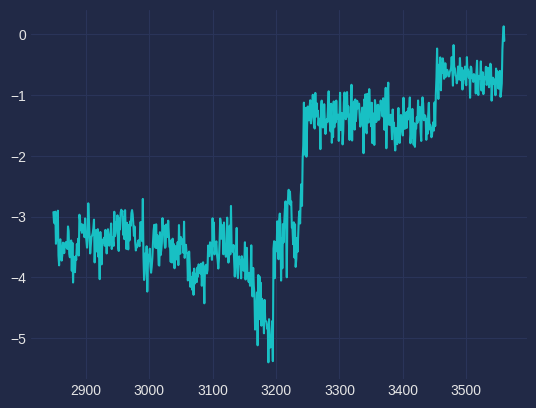

In [ ]:
plt.plot(y_test1)

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit
# tss = TimeSeriesSplit(n_splits=5, test_size=272, gap=0)

# fig, axs = plt.subplots(5, 1, figsize=(16, 8), sharex=True)

# fold = 0
# for train_idx, test_indx in tss.split(df_xgb):
#   train = df_xgb.iloc[train_idx]
#   test = df_xgb.iloc[test_indx]

#   train['Target'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
#   test['Target'].plot(ax=axs[fold], label='Test Set')

#   axs[fold].axvline(test.index.min(), color='w', ls='--')
#   fold += 1

# plt.show()

# fold = 0; preds = []; scores = []
# xgb_model = xgb.XGBRegressor( n_estimators = 1000, learning_rate=0.01, booster='gbtree',
#                               early_stopping_rounds=50, objective='reg:squarederror',
#                               max_depth = 8 )

# for train_idx, test_indx in tss.split(df_xgb):
#   train = df_xgb.iloc[train_idx]
#   test = df_xgb.iloc[test_indx]

#   x_train = train[features]; y_train = train[target]
#   x_test = test[features]; y_test = test[target]

#   xgb_model.fit(x_train, y_train,
#                 eval_set=[(x_train, y_train), (x_test, y_test)], verbose = 0)

In [ ]:
# eval_metric = RMSE (default)
xgb_model = xgb.XGBRegressor( n_estimators = 1000, learning_rate=0.01, n_jobs = -1  #,booster='gbtree'
                              ,early_stopping_rounds=150) #,max_depth = 8 )
xgb_model.fit(x_train1, y_train1,
              eval_set = [ (x_train1, y_train1), (x_test1, y_test1) ], verbose = 0)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=150,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Prediction

In [ ]:
y_predict_xgb = xgb_model.predict(x_test1)

y_test1 = np.ravel(y_test1)
y_predict_xgb = np.ravel(y_predict_xgb)

In [ ]:
mae = mean_absolute_error(y_predict_xgb, y_test1)
rmse = np.sqrt( np.mean(y_predict_xgb - y_test1)**2 )
mse = mean_squared_error(y_predict_xgb, y_test1)

print(f'\033[1mmae: {mae}\nrmse: {rmse}\nmse: {mse} \033[0m')

mae: 0.538858543955878
rmse: 0.03511054328318392
mse: 0.43342260080818656 


In [ ]:
x_plot = list( range( len(y_test) ) )

fig = px.line( template= 'plotly_dark' )
fig.add_scatter(x = x_plot, y = (y_test1), name = 'test') # ravel -> aplana los datos unidimensionales
fig.add_scatter(x = x_plot, y = (y_predict_xgb), name = 'predict')

fig.update_layout( xaxis_title ='Muestra', yaxis_title ='USD$', title = f'Ajuste de la Curva de Diferencias' )

In [ ]:
import plotly.figure_factory as ff

diff = (y_test1 - y_predict_xgb)
print(diff.mean())

fig = ff.create_distplot([diff], group_labels=['Diferencias'], bin_size = 0.01)

# Personaliza el diseño del gráfico
fig.update_layout( xaxis_title='Diferencias', yaxis_title='Densidad',
                  title='Histograma de Diferencias',
                  template='plotly_dark')

fig.add_shape(
    go.layout.Shape( type='line',
                     x0= 0, y0= 0, x1= 0, y1= 1,
                     line=dict(color='white', dash='dash'), )
            )

0.03511054328318392


#### Forecast

In [ ]:
# today_data = np.array(X.iloc[-1,:])
# today_data = np.reshape(today_data , (1, today_data.shape[0]) )

In [ ]:
# tomorrow = xgb_model.predict(today_data)
# print( f'Valor de {stock} para mañana: {tomorrow[0]:.3f} USD' )

## Moderate-Risk Assets

By September 2023 a AAA risk **Treasury Bond Note** is yielding 4.45%

<br>

This return will be our reference *Risk free Rate* $[R_f]$

### Load Data

In [ ]:
def annualize(returns, periods = 252):
  total_periodos = returns.shape[0]
  returns = (1+returns).prod()

  return returns**(periods/total_periodos) - 1

In [ ]:
def returns_df(original_df, name, mensual = False):
  '''
  Find the returns in time to create a Covariance Matrix
  between diferent stocks and find the Annualized return.
  '''

  if mensual:
    original_df['Date'] = pd.to_datetime(original_df['Date'])
    original_df.set_index('Date', inplace=True)

    original_df = original_df.resample('M').mean()

    original_df[name] = original_df['Adj Close'].pct_change()
    original_df.dropna(inplace = True)

  else:
    original_df[name] = original_df['Adj Close'].pct_change() # Retrono diario
    original_df.dropna(inplace = True)

  return original_df[[name]] # Retorno mensual


def load_moderate(stock, start = "2009-01-01", stop = today):

  sp500 = yf.download('VOO', start, stop); sp500.reset_index(inplace = True)
  nasdx = yf.download('VNQ', start, stop); nasdx.reset_index(inplace = True)
  stock_df = yf.download(stock, start, stop); stock_df.reset_index(inplace = True)
  lst = [sp500, nasdx, stock_df]

  d1 = returns_df(sp500, 'S&P500', True)
  d2 = returns_df(nasdx, 'VNQ', True)
  d3 = returns_df(stock_df, stock, True)

  returns_history = pd.merge(d1, d2, left_index=True, right_index=True, how='inner')
  returns_history = pd.merge(returns_history, d3, left_index=True, right_index=True, how='inner')

  return returns_history

returns_history = load_moderate(stock)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
print(returns_history.shape)
returns_history.head(5)

(156, 3)


,S&P500,VNQ,EC
Date,,,
2010-10-31,0.036871,0.037218,0.145276
2010-11-30,0.024907,0.000123,-0.004752
2010-12-31,0.037903,0.003383,-0.073532
2011-01-31,0.034338,0.033340,-0.004951
2011-02-28,0.031309,0.041239,-0.015823


(156, 3)


,S&P500,VNQ,EC
Date,,,
2010-10-31,0.036871,0.037218,0.145276
2010-11-30,0.024907,0.000123,-0.004752
2010-12-31,0.037903,0.003383,-0.073532
2011-01-31,0.034338,0.033340,-0.004951
2011-02-28,0.031309,0.041239,-0.015823


### Markowitz Efficient Frontier

Generating the efficient frontier requires a set of expected returns and a covariance matrix.

Since the lower the correlation of the assets, the lower the volatility will be.

In [ ]:
def portfolio_return(weights, returns):
  """
  Computes the return on a portfolio from constituent returns and weights

  Params.
    - weights are a Nx1 matrix
    - returns are a Nx1 matrix

  Where N is the total amount of stocks considered.
  """
  return weights.T @ returns

def portfolio_vol(weights, covmat):
  """
  Computes the volatility of a portfolio from a covariance matrix and constituent weights.

  Params.
  - Weights are a N x 1 maxtrix
  - covmat is an N x N matrix (Covariance Matrix)
  """
  return (weights.T @ covmat @ weights)**0.5


from scipy.optimize import minimize
def minimize_vol(target_return, expected_returns, cov):
  """
  Returns the optimal weights that achieve the target_return.
    Given a set of expected_returns and a covariance_matrix.

  weights : x   Optimization target parameter
  """

  # Initial values
  n = expected_returns.shape[0]
  init_guess = np.repeat(1/n, n)

  # Frontier values
  bounds = ((0, 1),) * n


  # Constraints   |   weights : x   target

  weights_sum_to_1 = {'type': 'eq', # Check when Constrain Function [fun] equals 0

                      # The funtion is 0 only when Σ(w) == 1  , So, only when x is equal to 1
                      'fun': lambda weights: np.sum(weights) - 1 }

  return_is_target = {'type': 'eq',
                      'args': (expected_returns,), # Additional parameter in 'fun' other than x

                      # So, return(x, expected_returns) equals target_return
                      'fun': lambda weights, er: target_return - portfolio_return(weights, er) }


  # Optimization Function
  weights = minimize(portfolio_vol, # Objective Function
                      init_guess, # Initial values
                      args=(cov,), # Extra arguments [ portfolio_vol(x, cov) ]
                      method='SLSQP', # Quadratic Optimizer

                      options={'disp': False},
                      constraints=(weights_sum_to_1,return_is_target),
                      bounds=bounds
                  )


  return weights.x # Return only the target parameter value

We already know how to identify points on the curve if we are given a target rate of return. Instead of minimizing the volatility based on a target return, we want to find that one point on the curve that maximizes the Sharpe Ratio, given the a risk free rate. In other words, the tangent point of the Efficient Frontier and the **Capital Market Line [CML]**.

In [ ]:
def msr(riskfree_rate, er, cov):
  """
  Returns the weights that achieve the Maximun Sharp Ratio Porfolio [MSR]

    S_p = ( promedio_retorno_portafolio - Rf ) / volatilidad_portafolio

    Por cada unidad de volatilidad, existen S_p unidades adicionales de Retorno;
    bajo un concepto de costo oportunidad en funcion del Rf

  weights : x   Optimization target parameter
  """

  # Initial values
  n = er.shape[0]
  init_guess = np.repeat(1/n, n)

  # Frontier values
  bounds = ((0, 1),) * n


  # Constraints   |   weights : x   target

  weights_sum_to_1 = {'type': 'eq', # Check when Constrain Function [fun] equals 0

                      # The funtion is 0 only when Σ(w) == 1  , So, only when x is equal to 1
                      'fun': lambda weights: np.sum(weights) - 1 }


  # Objective Function
  def neg_sharpe(weights, riskfree_rate, er, cov):
    """
    Returns the negative (so it can be minimized) of the sharpe ratio of the given portfolio
    """
    r = portfolio_return(weights, er)
    vol = portfolio_vol(weights, cov)
    return -(r - riskfree_rate)/vol


  # Optimization Function
  weights = minimize(neg_sharpe,
                      init_guess, # Initial values
                      args= (riskfree_rate, er, cov),
                      method= 'SLSQP', # Quadratic Optimizer

                      options= {'disp': False},
                      constraints= (weights_sum_to_1),
                      bounds= bounds
                  )


  return weights.x

There is another point on the efficient frontier that is very interesting. This is the _extreme_ of the convex curve, which is the portfolio of lowest volatility across all possible portfolios. This is called the Minimum Volatility or the **Global Minimum Volatility Portfolio [GMV]**.

The interesting thing about it is that if we assume that all returns are the same, the optimizer cannot improve the sharpe ratio through raising returns, and so it must do so my lowering volatility. This means that if we just skip any returns estimation and assume all returns are just the same, we'd get the weights of the GMV portfolio.

In [ ]:
def gmv(cov):
  """
  Returns the weights of the Global Minimum Volatility portfolio
  given a covariance matrix.
  """
  n = cov.shape[0]
  return msr(0, np.repeat(1, n), cov)

In [ ]:
def plot_ef(n_points = 100, expected_returns = None, cov = None, style='-', show_cml= True, riskfree_rate= 0.0445, show_ew = True , show_gmv = True):
  """
  Plots the multi-asset efficient frontier
  """

  def optimal_weights(n_points, expected_returns, cov):
    """
    Returns a list of weights that represent a grid of n_points on the efficient frontier
    """
    target_rs = np.linspace(expected_returns.min(), expected_returns.max(), n_points)
    weights = [minimize_vol(target_return, expected_returns, cov) for target_return in target_rs]

    return weights


  weights = optimal_weights(n_points, expected_returns, cov)
  rets = [portfolio_return(w, expected_returns) for w in weights]
  vols = [portfolio_vol(w, cov) for w in weights]

  ef = pd.DataFrame({ "Returns": rets,  "Volatility": vols })

  fig, ax = plt.subplots()
  ef.plot.line(ax = ax, x="Volatility", y="Returns", style=style, legend= True, label = 'Posibles Portafolios', color= 'darkturquoise')

  if show_cml:
    #ax.set_xlim(left = 0)

    # get MSR
    w_msr = msr(riskfree_rate, expected_returns, cov)
    r_msr = portfolio_return(w_msr, expected_returns)
    vol_msr = portfolio_vol(w_msr, cov)

    # add CML
    cml_x = [0, vol_msr]
    cml_y = [riskfree_rate, r_msr]
    ax.plot(cml_x[1], cml_y[1], color='magenta', marker='*', markersize=7.5)
    ax.text( vol_msr + 0.0003, r_msr + 0.0003, 'MSR', color='magenta' )

  if show_ew:
    n = expected_returns.shape[0]

    w_ew = np.repeat(1/n, n)
    r_ew = portfolio_return(w_ew, expected_returns)
    vol_ew = portfolio_vol(w_ew, cov)

    # EW
    ax.plot([vol_ew], [r_ew], color='gold', marker='o', markersize= 5)
    ax.text( vol_ew + 0.0005, r_ew + 0.0005, 'EW', color='gold' )

  if show_gmv:
    w_gmv = gmv(cov)
    r_gmv = portfolio_return(w_gmv, expected_returns)
    vol_gmv = portfolio_vol(w_gmv, cov)

    # GMW
    ax.plot([vol_gmv], [r_gmv], color='ivory', marker='o', markersize= 5)
    ax.text( vol_gmv + 0.0005, r_gmv + 0.001, 'GMV', color='ivory', fontweight='bold' )

  fig.suptitle("Frontera de Eficiencia de Markowitz")
  ax.set_ylabel("Retornos Anualizados"); ax.set_xlabel("Volatilidad")

  fig.show()

  w_msr = np.array(w_msr).round(2); w_gmv = np.array(w_gmv).round(2)
  return [w_msr, r_msr, vol_msr], [w_gmv, r_gmv, vol_gmv]

In [ ]:
expected_returns = annualize(returns_history, 12)
cov_matrix = returns_history.cov()

In [ ]:
expected_returns

S&P500    0.131396
VNQ       0.073492
EC       -0.031039
dtype: float64

S&P500    0.131396
VNQ       0.073492
EC       -0.031039
dtype: float64

In [ ]:
cov_matrix

,S&P500,VNQ,EC
S&P500,0.001079,0.000959,0.001478
VNQ,0.000959,0.001613,0.001167
EC,0.001478,0.001167,0.009681


,S&P500,VNQ,EC
S&P500,0.001079,0.000959,0.001478
VNQ,0.000959,0.001613,0.001167
EC,0.001478,0.001167,0.009681


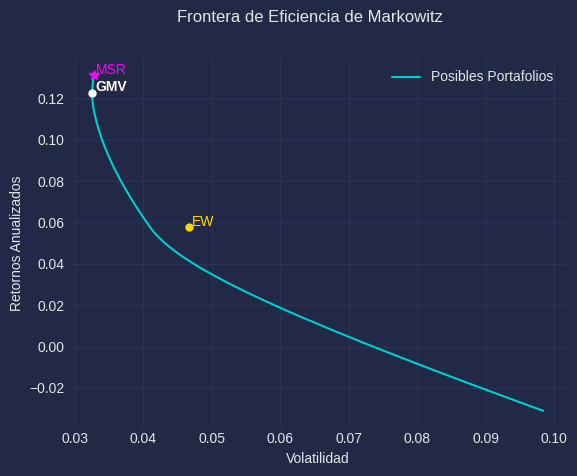

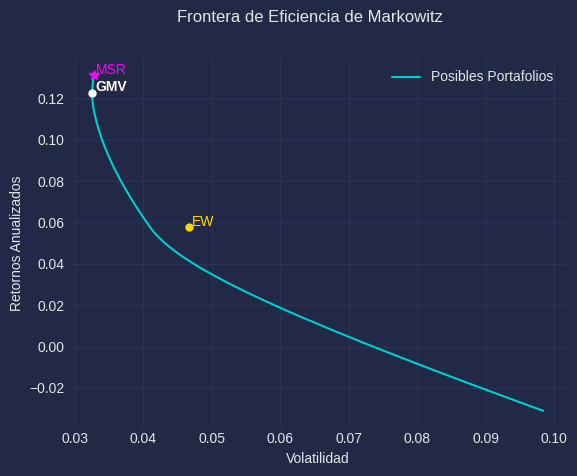

In [ ]:
msr_port, gmv_port = plot_ef(100, expected_returns, cov_matrix, show_cml= True)

In [ ]:
print( f'MSR\nR_p = {msr_port[1]:.4f}\nσ_p = {msr_port[2]:.4f}\nPesos = {msr_port[0]}\n' )

print( f'GMV\nR_p = {gmv_port[1]:.4f}\nσ_p = {gmv_port[2]:.4f}\nPesos = {gmv_port[0]}' )

MSR
R_p = 0.1314
σ_p = 0.0329
Pesos = [1. 0. 0.]

GMV
R_p = 0.1224
σ_p = 0.0326
Pesos = [0.84 0.16 0.  ]
MSR
R_p = 0.1314
σ_p = 0.0329
Pesos = [1. 0. 0.]

GMV
R_p = 0.1224
σ_p = 0.0326
Pesos = [0.84 0.16 0.  ]


### CPPI simulation
**Implementing Portfolio Insurance (CPPI) and Drawdown Constraints**




In [ ]:
import ipywidgets as widgets
from IPython.display import display

In [ ]:
def sim_cppi(risky_r, safe_returns = None, m = 3, S0 = 100, floor = 0.8, riskfree_rate = 0.0445, drawdown = None):
  """
  Run a backtest of the CPPI strategy, given a set of returns for the risky asset
  Returns a dictionary containing: Asset Value History, Risk Budget History, Risky Weight History
  """
  # set up the CPPI parameters
  dates = risky_r.index
  n_steps = len(dates)
  account_value = S0
  floor_value = S0*floor
  peak = account_value


  # Set Safe Bonds returns by current RiskFree Rate
  if safe_returns is None:
    safe_returns = pd.DataFrame().reindex_like(risky_r)
    safe_returns.values[:] = riskfree_rate/12 # fast way to set all values to a number


  # Set DataFrames for saving intermediate values
  account_history = pd.DataFrame().reindex_like(risky_r)
  risky_w_history = pd.DataFrame().reindex_like(risky_r)
  cushion_history = pd.DataFrame().reindex_like(risky_r)
  floorval_history = pd.DataFrame().reindex_like(risky_r)
  peak_history = pd.DataFrame().reindex_like(risky_r)


  for step in range(n_steps):
    # By default, drawdown is set to fixed floor in fuction to Initial Investment S0
    # If defined, floor will grow in proportion to most recent peak
    if drawdown is not None:
      peak = np.maximum(peak, account_value)
      floor_value = peak*(1-drawdown)

    cushion = (account_value - floor_value)/account_value

    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)

    safe_w = 1-risky_w

    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w

    # recompute the new account value at the end of this step
    account_value = risky_alloc*( 1 + risky_r.iloc[step] ) + safe_alloc*( 1 + safe_returns.iloc[step] )

    # save the histories for analysis and plotting
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
    floorval_history.iloc[step] = floor_value
    peak_history.iloc[step] = peak

  risky_wealth = S0*(1+risky_r).cumprod()


  simulation = {"Wealth": account_history,
                "Risky Wealth": risky_wealth,
                "Risk Budget": cushion_history,
                "Risky Allocation": risky_w_history,
                "m": m,
                "S0": S0,
                "floor": floor,
                "risky_r":risky_r,
                "safe_returns": safe_returns,
                "drawdown": drawdown,
                "peak": peak_history,
                "floor": floorval_history
                }

  return simulation

The stochastic model for asset returns is given by the Geometric Brownian Motion process:

$$ \frac{S_{t+dt}-S_t}{S_t} = \mu dt + \sigma\sqrt{dt}\xi_t $$

Where

$$ \mu = r + \sigma \lambda^s $$

When we generate simulated returns, we can usually ignore the decomposition of $\mu$ since we only care about the net effective drift term $\mu dt$ without worrying about what the components of it are.

In [ ]:
def brownian_motion(n_years = 10, n_scenarios = 100, mu = 0.07, sigma = 0.15, steps_per_year = 12, S0 = 100.0, en_dolares = False):
  """
  Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices.

  Parameters:
    years:  The number of years to generate data for
    scenarios: The number of different scenarios/trajectories
    mu: Annualized Drift, i.e Market Return
    sigma: Annualized Volatility
    steps_per_year: granularity of the simulation; periods per year
    S_0: initial value

  Return:
    Columns amount of scenarios
    Rows years * steps_per_year
  """
  np.random.seed(1)

  dt = 1/steps_per_year ;  n_steps = int(n_years*steps_per_year) + 1
                # data distribution    drift           volatility
  rets_plus_1 = np.random.normal(loc= ( 1 + mu )**dt, scale=(sigma*np.sqrt(dt)), size=(n_steps + 1, n_scenarios))
  rets_plus_1[0] = 1

                                                              # Raw Returns
  res = S0*pd.DataFrame(rets_plus_1).cumprod() if en_dolares else (rets_plus_1 - 1)
  return res

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…

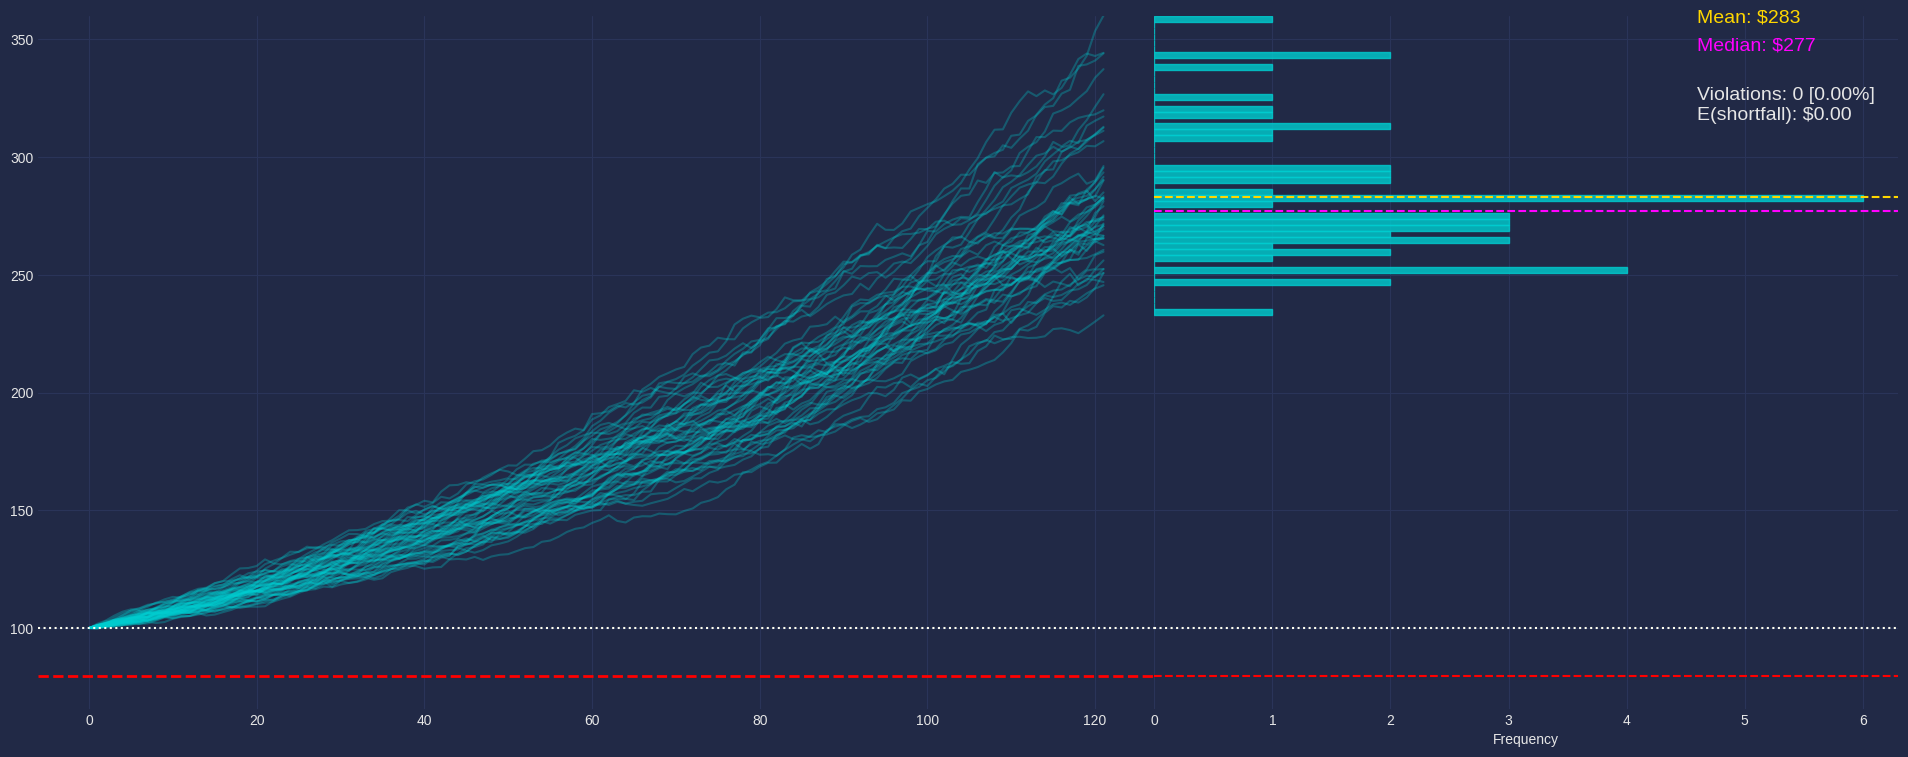

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…

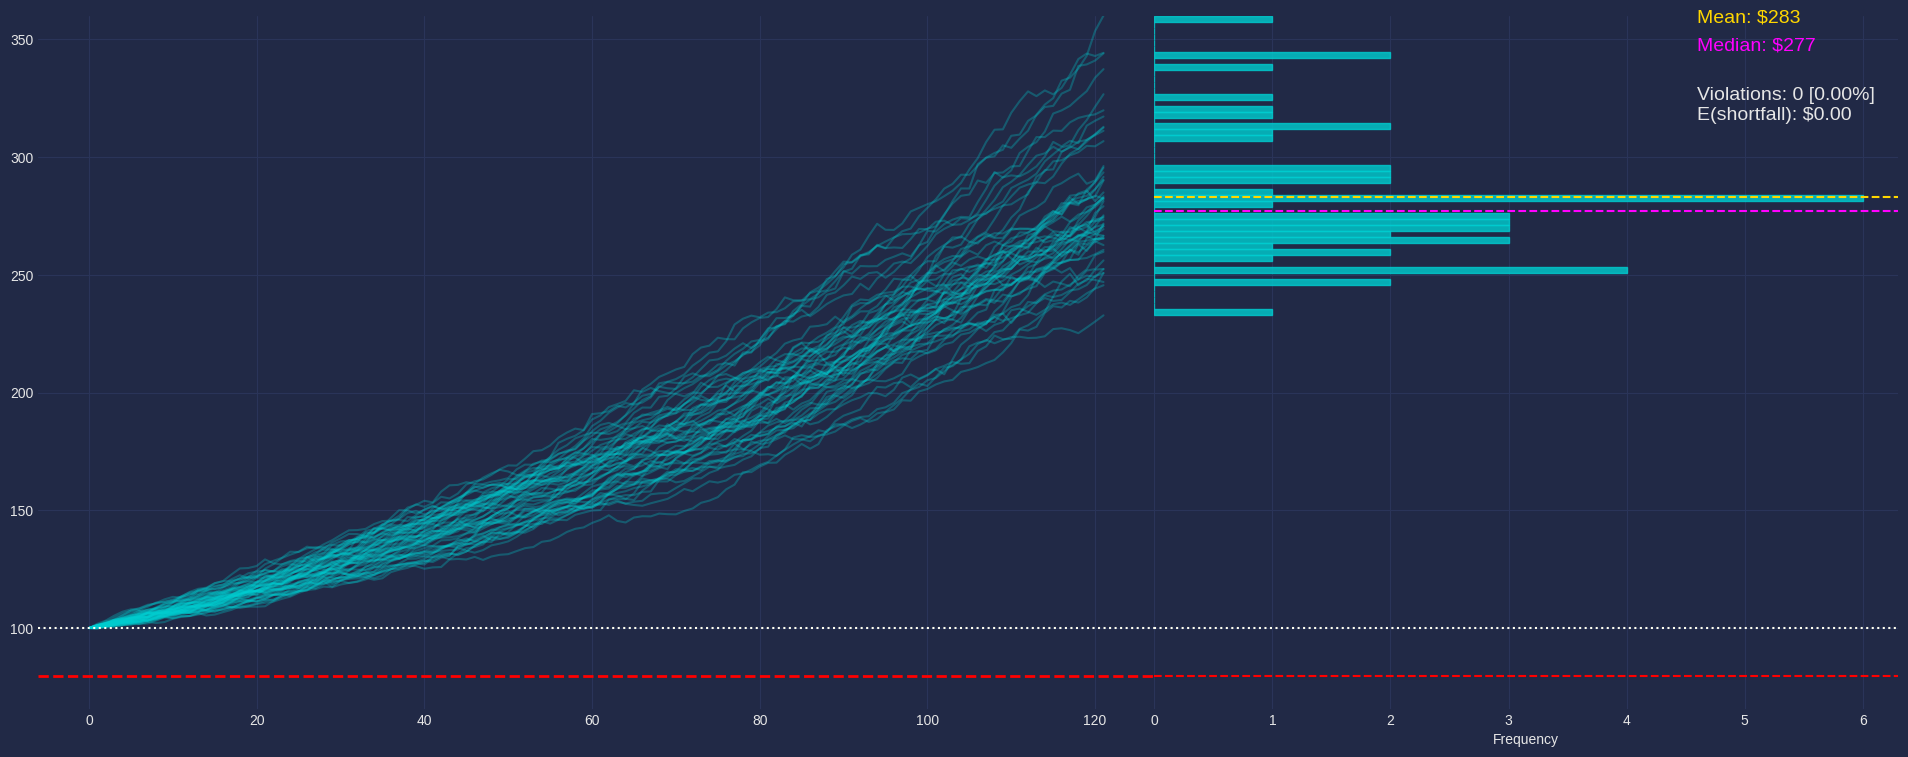

In [ ]:
def plot_cppi(n_scenarios = 100, mu = 0.11, sigma = 0.03, m = 3, floor = 0.8, riskfree_rate = 0.0445, y_max = 100, steps_per_year = 12):
  """
  Plot the results of a Monte Carlo Simulation of CPPI

    - n : total scenarios
    - mu : weighted avg. of portfolio returns
    - sigma : weighted volatility of portfolio
    - m : Risky asset multiplier
    - floor : maximun acetable proportion of losses by initial investment [S0]
    - R_f : risk free rate (Treasury Bond)
    - y_max : plot y axis scale
    - steps_per_year : CPPI portfolio actualization frequency. ( default: monthly )
  """
  S0  = 100 # Nominal Inicial
  sim_rets = brownian_motion(n_scenarios = n_scenarios, mu = mu, sigma = sigma, steps_per_year = steps_per_year)
  risky_r = pd.DataFrame(sim_rets) # Retornos generados con mov. Borowniano



  # Run the back-test
                           # working with Series may prove to be inconvinient
  sim = sim_cppi(risky_r = pd.DataFrame(risky_r), riskfree_rate = riskfree_rate, m = m, S0 = S0 , floor=floor)
  wealth = sim["Wealth"]
  y_max = wealth.values.max()*y_max/100 # y axis Zoom



  # Calculate terminal wealth stats

  terminal_wealth = wealth.iloc[-1]

  tw_mean = terminal_wealth.mean()  # ret. promedio
  tw_median = terminal_wealth.median() # ret. medio

  fail = np.less(terminal_wealth, S0*floor)
  n_failures = fail.sum()
  p_fail = n_failures/n_scenarios

  avg_shortfall = np.dot( terminal_wealth - S0 * floor,  fail ) / n_failures if (n_failures > 0) else 0



  # Plot

  fig, (wealth_ax, hist_ax) = plt.subplots(nrows = 1, ncols = 2, sharey = True, gridspec_kw={'width_ratios':[3,2]}, figsize=(24, 9))
  plt.subplots_adjust(wspace=0.0) # Adjacent plots

  wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="darkturquoise")
  wealth_ax.axhline(y= S0, ls=":", color="ivory")
  wealth_ax.axhline(y= S0*floor, ls="--", color="red", linewidth=2)
  wealth_ax.set_ylim(top=y_max)



  terminal_wealth.plot.hist(ax = hist_ax, bins=50, ec='darkturquoise', fc='darkturquoise', orientation='horizontal', alpha = 0.8)
  hist_ax.axhline(y= S0, ls=":", color="ivory")
  hist_ax.axhline(y= tw_mean, ls="--", color="gold")
  hist_ax.axhline(y= tw_median, ls="--", color="magenta")



  hist_ax.annotate(f"Mean: ${int(tw_mean)}", xy=(0.73, 0.99),xycoords='axes fraction', fontsize= 14, color = 'gold')
  hist_ax.annotate(f"Median: ${int(tw_median)}", xy=(0.73, 0.95),xycoords='axes fraction', fontsize= 14, color = 'magenta')

  if (floor > 0.01):
    hist_ax.axhline(y=S0*floor, ls="--", color="red", linewidth=1.5)
    hist_ax.annotate(f'Violations: {n_failures} [{p_fail*100:2.2f}%]\nE(shortfall): ${avg_shortfall:2.2f}', xy=(0.73, 0.85), xycoords='axes fraction', fontsize= 14)



cppi_controls = widgets.interactive(plot_cppi,
                                    n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50),
                                    mu=(-0.2, 0.2, 0.01),
                                    sigma=(0, 0.2, 0.01),
                                    floor=(0, 2, 0.1),
                                    m=(1, 5, 0.5),
                                    riskfree_rate=(0, 0.05, 0.01),
                                    y_max = widgets.IntSlider(min=0, max=100, step=1, value=100, description="Zoom y axis"),
                                    steps_per_year = widgets.IntSlider(min=1, max=12, step=1, value=12, description="Periods per Year")
                            )
display(cppi_controls)

# Save Model

In [ ]:
# save_string = f'{stock}.h5'
# lstm.save(save_string)